# Querying MAPS data with Spark

Setup the spark session. These files are small, so we can fit more tasks onto executors. Seems like 4 cores / 4GB works. Total of 120 cores means we can fit 29 (since we need a core for the driver)

In [1]:
%%configure -f
{"name": "arik-manga-maps-query", "executorMemory": "4G", "numExecutors": 32, "executorCores": 4,
 "conf": {"spark.yarn.appMasterEnv.PYSPARK_PYTHON":"python3"}}

In [2]:
import time
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
33,application_1588740809550_0036,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
rcParams.update({'xtick.minor.visible': True, 'xtick.direction': 'in', 'ytick.direction': 'in',
                 'xtick.top': True, 'ytick.right': True, 'figure.figsize': (14,8), 'xtick.labelsize':16,
                'ytick.labelsize':16, 'axes.labelsize':16, 'font.family': 'serif', 'font.weight': 0})

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
timer = 0
def ts():
    global timer
    timer = time.time()
def tt(msg='time'):
    global timer
    print('{}: {:0.2f}s'.format(msg, time.time()-timer))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Load the table

In [5]:
hdfs_dir = 'hdfs:///manga/arik-test/dr15/v2_4_3/maps'

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
df = spark.read.parquet(hdfs_dir)
df.createOrReplaceTempView('data')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Simple count
This is a very simple query which should be accessing only the per-file summary data of parquet and not doing a scan. As with other query examples, since some of the structure is lazy loaded and the first query will fill OS-level file caches, we see a substantial difference between the first instance of the count and the following one.

In [7]:
ts()
spark.sql('''select count(*) from data''').show()
tt()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+
| count(1)|
+---------+
|182235416|
+---------+

time: 9.01s

In [57]:
ts()
spark.sql('''select count(*) from data''').show()
tt()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+
| count(1)|
+---------+
|182235416|
+---------+

time: 0.42s

### Aggregations
Here we get the total flux across the whole catalog by line. This has to scan the entire dataset, but only loading the LINE and EMLINE_SFLUX columns to do the aggregation. I'm not sure what we should expect here, but consider the catalog size of ~4GB and 4722 objects.

In [58]:
ts()
spark.sql('''
SELECT 
LINE,count(*) AS N,SUM(EMLINE_SFLUX) AS SFLUX 
FROM data
GROUP BY LINE 
ORDER BY SFLUX DESC
''').show()
tt()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-------+--------------------+
|      LINE|      N|               SFLUX|
+----------+-------+--------------------+
|   Ha-6564|8283428|1.1750418669630302E7|
| OIId-3728|8283428|      6279372.181325|
|  NII-6585|8283428|  4407205.3984093275|
|   Hb-4862|8283428|  3010690.9568863055|
| OIII-5008|8283428|  2725248.6934399754|
|  SII-6718|8283428|   2272453.912795613|
|  SII-6732|8283428|   1638582.317993458|
|  NII-6549|8283428|  1527629.4554739622|
| Hgam-4341|8283428|  1392033.2677033453|
| OIII-4960|8283428|    910515.003056286|
| Hzet-3890|8283428|   672365.5652368448|
| Hdel-4102|8283428|   655748.7333435712|
| Heps-3971|8283428|   594010.9594513059|
|NeIII-3968|8283428|    567338.505721442|
|   OI-6302|8283428|  500060.99806820345|
|NeIII-3869|8283428|   449887.5563996445|
|  HeI-5877|8283428|   238215.7345408954|
| Hthe-3798|8283428|  221000.91603253354|
|   OI-6365|8283428|  105837.45383506572|
| Heta-3836|8283428|   45069.52726877873|
+----------+-------+--------------

### Drill down into distribution for Ha
Lets use the MAPS data to find some objects with high Ha emmision to drill down to looking at individual spectra. So first, lets get an idea of the Ha flux distribution across the catalog. Below, by grouping by PLATEID,IFUDSGN we can get each object (I think - is this equivalent to grouping by MANGAID?)

In [59]:
ts()
ha_flux = spark.sql('''
SELECT PLATEID,IFUDSGN,SUM(EMLINE_SFLUX) AS SFLUX
FROM data
WHERE LINE = 'Ha-6564'
GROUP BY PLATEID,IFUDSGN''').toPandas()
tt()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

time: 1.55s

In [62]:
plt.clf()
plt.hist(ha_flux.query('SFLUX < 800000')['SFLUX']/100000, histtype='step', color='k', log=True)
plt.xlabel('flux (1e-22 erg/s/cm2/spaxel)'), plt.ylabel('Count/bin')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(Text(0.5, 0, 'flux (1e-22 erg/s/cm2/spaxel)'), Text(0, 0.5, 'Count/bin'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

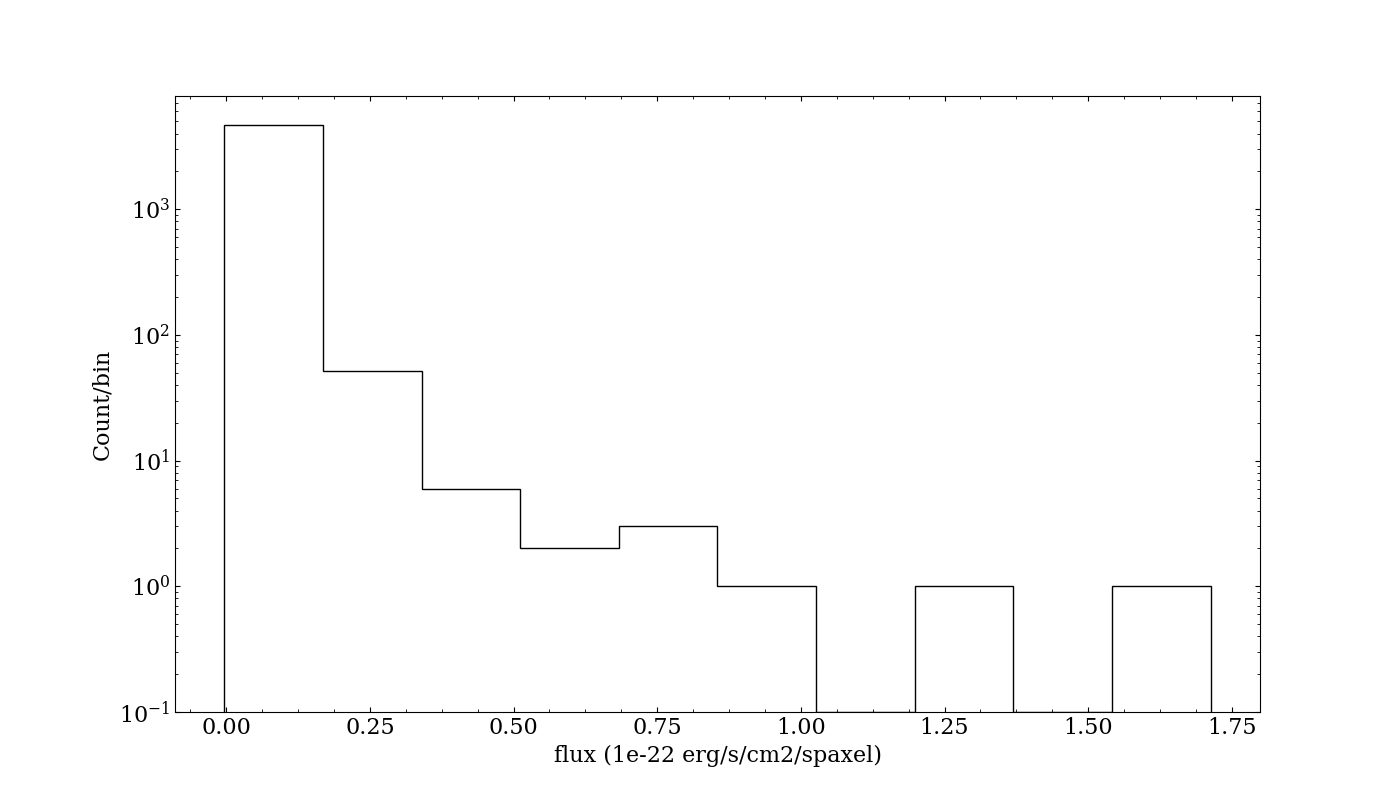

In [63]:
%matplot plt

Now we can use this to inform a cut on Ha to get the several highest flux object that we can infer from the plot above. I will make a cut at FLUX > 1.1e5, which ends up with 3 objects.

In [12]:
ts()
lots_of_halpha = spark.sql('''
SELECT MANGAID, SFLUX FROM (
  SELECT MANGAID,SUM(EMLINE_SFLUX) AS SFLUX FROM data 
  WHERE LINE='Ha-6564'
  GROUP BY MANGAID
) 
WHERE SFLUX > 110000
''').toPandas()
tt()
lots_of_halpha

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

time: 3.99s
  MANGAID         SFLUX
0   51-49  1.173184e+06
1   51-17  1.713092e+05
2   51-14  1.343004e+05

We have used the MAPS data to discover objects of interest, so lets turn to the logcube files to extract spectra for these. Below we load the logcube table and then construct spectra by querying by MANGAID in the above set. Technically, a simpler way to express this in SQL is a single join query, but I have not yet identified a way to do this optimized in spark to avoid large shuffles. We *want* to create a join that has the set of 3 on the left side, but spark is not planning this way. In any case, this is pretty simple and seems efficient enough.

In [13]:
logcube = 'hdfs:///manga/arik-test/dr15/v2_4_3/logcube_voxel'
lc = spark.read.parquet(logcube)
lc.createOrReplaceTempView('logcube')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
ts()
specs = spark.sql('''
SELECT MANGAID, WAVE, SUM(FLUX) AS FLUX
FROM logcube WHERE MANGAID IN {}
GROUP BY MANGAID, WAVE
'''.format(tuple(lots_of_halpha['MANGAID']))).toPandas()
tt()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

time: 21.54s

In [15]:
plt.clf()
for mid in set(specs['MANGAID']):
    s = specs[specs['MANGAID'] == mid].sort_values('WAVE')
    plt.plot(s['WAVE'], s['FLUX'])
plt.xlim((6530,6630))
plt.xlabel('Wavelength'), plt.ylabel('Flux')
plt.axvline(6564, c='k')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Here are our spectra around the Ha line (rest location indicated by vertical line). As we may have noted in the table output, one of the objects has about an order of magnitude more Ha flux than the other two (which themselves have similar levels), and this can easily be seen in the plot below.

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

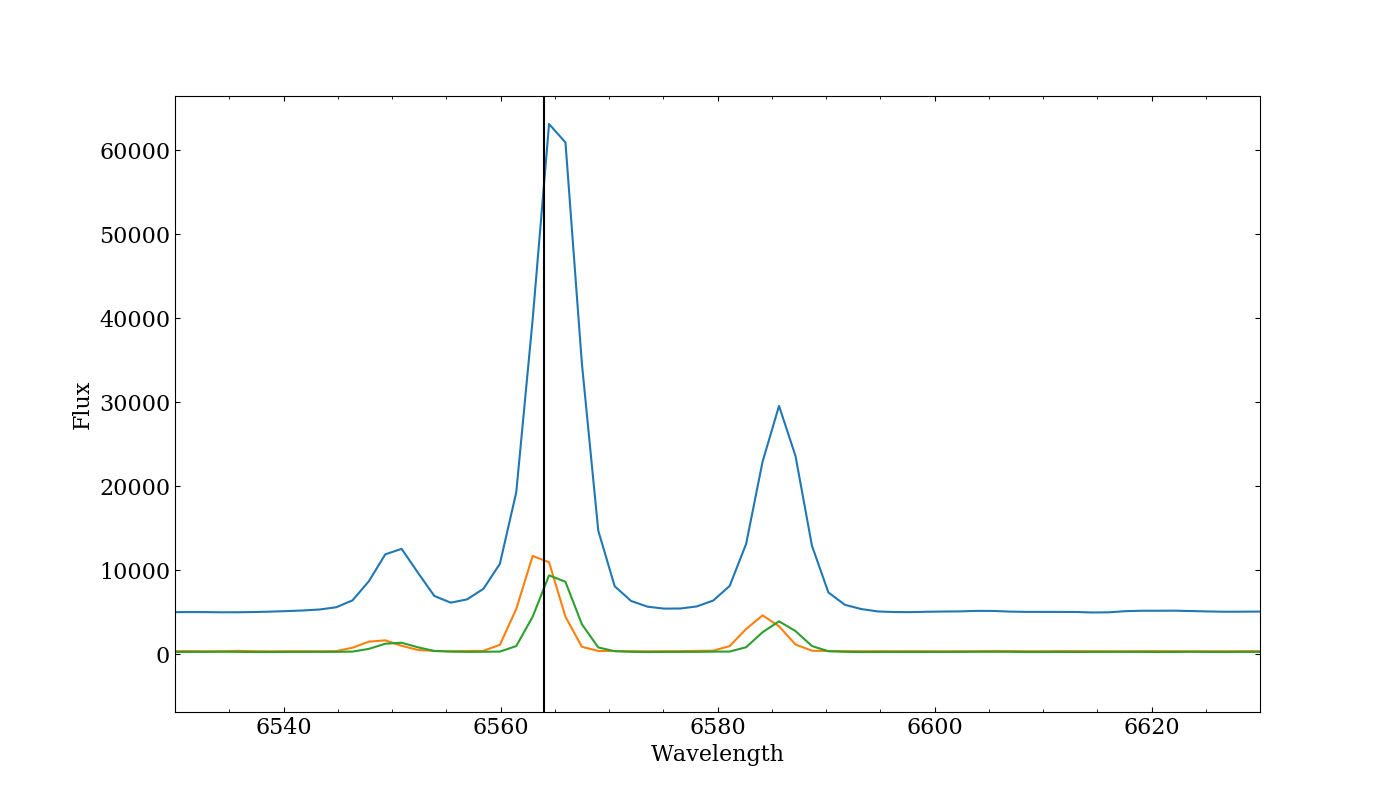

In [16]:
%matplot plt

### Drill further into spatial distribution for a single object
Lets drill further on the strongest emitter of the above three. As an example use-case, let's compare the flux in the central region of the galaxy and an annular region around it, from the perspective of the g-band flux. I took the simplistic circular regions, but one can imagine a shape more tuned to the projection of the galaxy in the image. Equally, one could imagine drawing a region around the two bright regions in Ha.

The main difference in time in the queries below is the size of data and layout. The logcube data has a row per wave element per spaxel whereas the maps table has just one row per spaxel. Extracting the broadband image in this way from the logcube is a bit of an abuse - they actually would fit more naturally in the maps table.

In any case, both of these queries are still efficient compared to data size due to sparks ability to reject scanning within a file by looking up summary statistics (for PLATEID and IFUDSGN in both cases). It reads a bunch of footer metadata but ends up scanning only a single file.

In [17]:
ts()
gimg = spark.sql('''
SELECT first(G) AS G, _SRC_X, _SRC_Y, first(RA) RA, first(DEC) DEC FROM
logcube WHERE PLATEID=9675 AND IFUDSGN=12703
GROUP BY _SRC_X, _SRC_Y
''').toPandas()
tt()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

time: 19.18s

In [18]:
ts()
haimg = spark.sql('''
SELECT _SRC_X, _SRC_Y, RA, DEC, EMLINE_SFLUX
FROM data WHERE PLATEID=9675 AND IFUDSGN=12703 AND LINE='Ha-6564'
''').toPandas()
tt()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

time: 0.50s

In [19]:
plt.clf()
img = np.zeros((gimg['_SRC_Y'].max()+1, gimg['_SRC_X'].max()+1))
img[gimg['_SRC_Y'], gimg['_SRC_X']] = gimg['G']
img2 = np.zeros((gimg['_SRC_Y'].max()+1, gimg['_SRC_X'].max()+1))
img2[haimg['_SRC_Y'], haimg['_SRC_X']] = haimg['EMLINE_SFLUX']
fig, ax = plt.subplots(2,1)
ext = (gimg['RA'].min(), gimg['RA'].max(), gimg['DEC'].min(), gimg['DEC'].max())
ax[0].imshow(img, extent=ext)
t=np.arange(0, 2*np.pi+0.1, 0.1)
cra, cde = 56.7032, 68.0967
di, do = 0.0007, 0.0014
x1=cra+di*np.cos(t)
y1=cde+di*np.sin(t)
x2=cra+do*np.cos(t)
y2=cde+do*np.sin(t)
ax[0].plot(x1,y1)
ax[0].plot(x2,y2)
ax[1].imshow(img2, extent=ext)
ax[1].plot(x1,y1)
ax[1].plot(x2,y2)
ax[0].set_title('G')
ax[1].set_title('Ha')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0.5, 1.0, 'Ha')

Below I've just made up a region by eye to get an annulus around the central bulge in G.

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

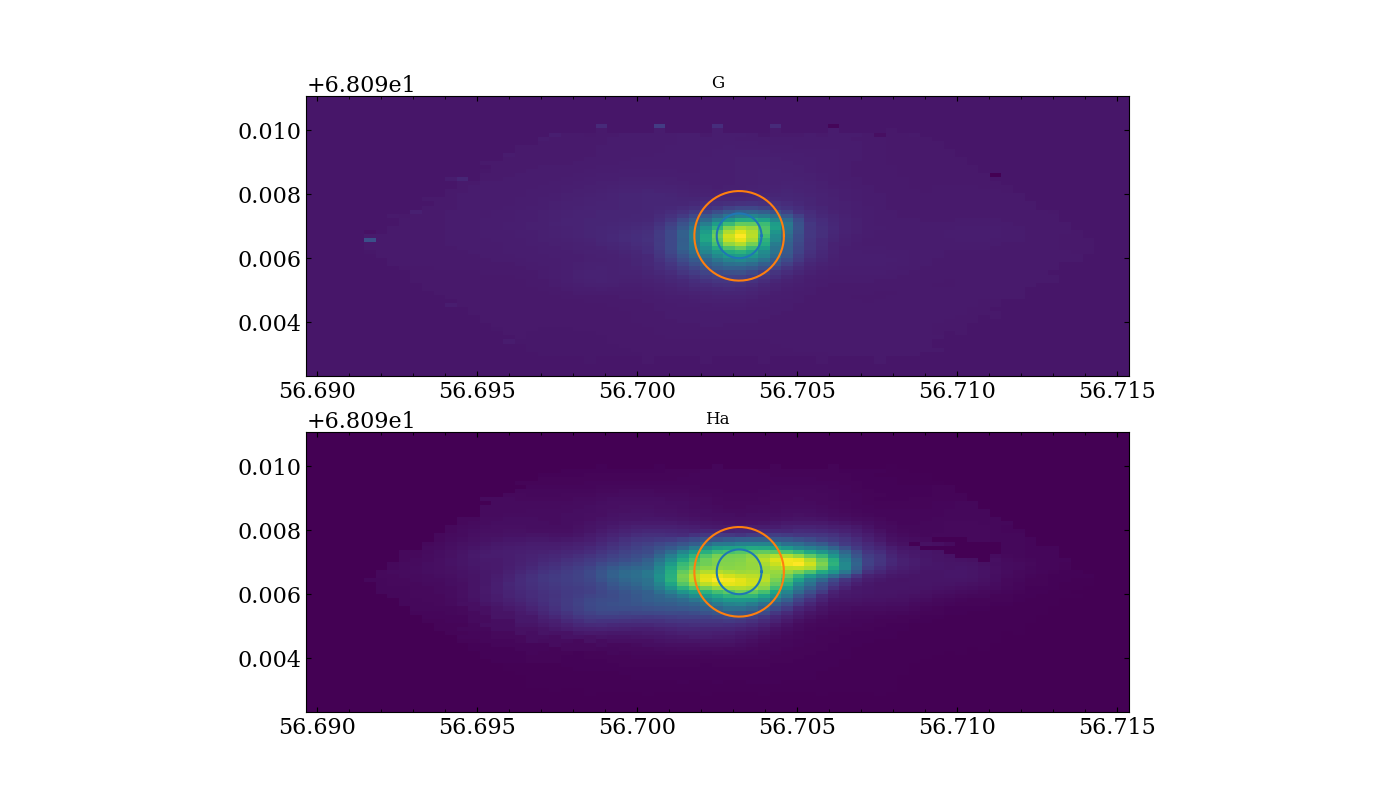

In [20]:
%matplot plt

Lets just first tabulate the summed flux in the annular region for each line in the catalog. Again, using PLATEID and IFUDSGN cut out a lot of data, and the extra time here is for the region selection computation as well as aggregation.

In [21]:
ts()
annul_lin_flux = spark.sql(
'''
SELECT LINE, SUM(EMLINE_SFLUX) AS SFLUX
FROM data WHERE PLATEID=9675 AND IFUDSGN=12703 AND 
(pow(RA-{cra},2) + pow(DEC-{cde},2)) < {ddo} AND (pow(RA-{cra}, 2) + pow(DEC-{cde}, 2)) > ({ddi})
GROUP BY LINE
ORDER BY SFLUX DESC
'''.format(cra=cra, cde=cde, ddo=do**2, ddi=di**2)
).toPandas()
tt()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

time: 1.23s

In [22]:
annul_line_flux

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

          LINE          SFLUX
0      Ha-6564  389295.207458
1     NII-6585  155853.789047
2      Hb-4862   90588.974976
3     NII-6549   53260.870010
4     SII-6732   37803.423637
5     SII-6718   37571.555763
6    Hgam-4341   33440.560570
7    OIId-3728   30902.968239
8    Hdel-4102   21358.134424
9    OIII-5008   11298.598572
10    HeI-5877    8862.953797
11  NeIII-3968    7490.255147
12   Heps-3971    6954.469955
13   Hzet-3890    6081.043686
14   OIII-4960    4767.300375
15     OI-6302    4033.225705
16   HeII-4687    3330.620620
17  NeIII-3869    2144.560390
18   Hthe-3798    1579.357870
19     OI-6365     231.814535
20    OII-3729       0.000000
21   Heta-3836   -5675.467702

Lets compare the specta in these regions. Here we have to consult the logcube data and I obtain one spectrum for each of the annulus and the core.

In [27]:
ts()
outer_spec = spark.sql('''
SELECT WAVE, SUM(FLUX) AS FLUX
FROM logcube
WHERE 
 PLATEID=9675 AND IFUDSGN=12703 AND 
 sqrt(pow(RA-{cra}, 2) + pow(DEC-{cde}, 2)) < {do} AND sqrt(pow(RA-{cra}, 2) + pow(DEC-{cde}, 2)) > {di}
GROUP BY WAVE
ORDER BY WAVE
'''.format(cra=cra, cde=cde, do=do, di=di)
).toPandas()
tt()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

time: 17.28s

In [28]:
ts()
inner_spec = spark.sql('''
SELECT WAVE, SUM(FLUX) AS FLUX
FROM logcube
WHERE 
 PLATEID=9675 AND IFUDSGN=12703 AND 
 sqrt(pow(RA-{cra}, 2) + pow(DEC-{cde}, 2)) < {di}
GROUP BY WAVE
ORDER BY WAVE
'''.format(cra=cra, cde=cde, do=do, di=di)
).toPandas()
tt()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

time: 17.13s

In [55]:
plt.clf()
fig, ax = plt.subplots(2,1)
ax[0].plot(outer_spec['WAVE'], outer_spec['FLUX'], c='k')
ax[0].plot(inner_spec['WAVE'], inner_spec['FLUX'], c='silver')
ax[0].set_yscale('log')
ax[1].plot(outer_spec['WAVE'], outer_spec['FLUX'], c='k')
ax[1].plot(inner_spec['WAVE'], inner_spec['FLUX']+430, c='silver')
ax[1].set_xlim((6500,6800))
ax[1].set_xlabel('WAVE')
ax[1].set_ylabel('Sum FLUX')
ax[0].set_ylabel('Sum FLUX')
ax[1].legend(('outer region','inner region'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The first panel is a comparison of the whole spectrum, while the second shows a small wavelength region and the inner region spectrum as been shifted to match continuum emission between inner and outer so comparisons of emission lines can be made.

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

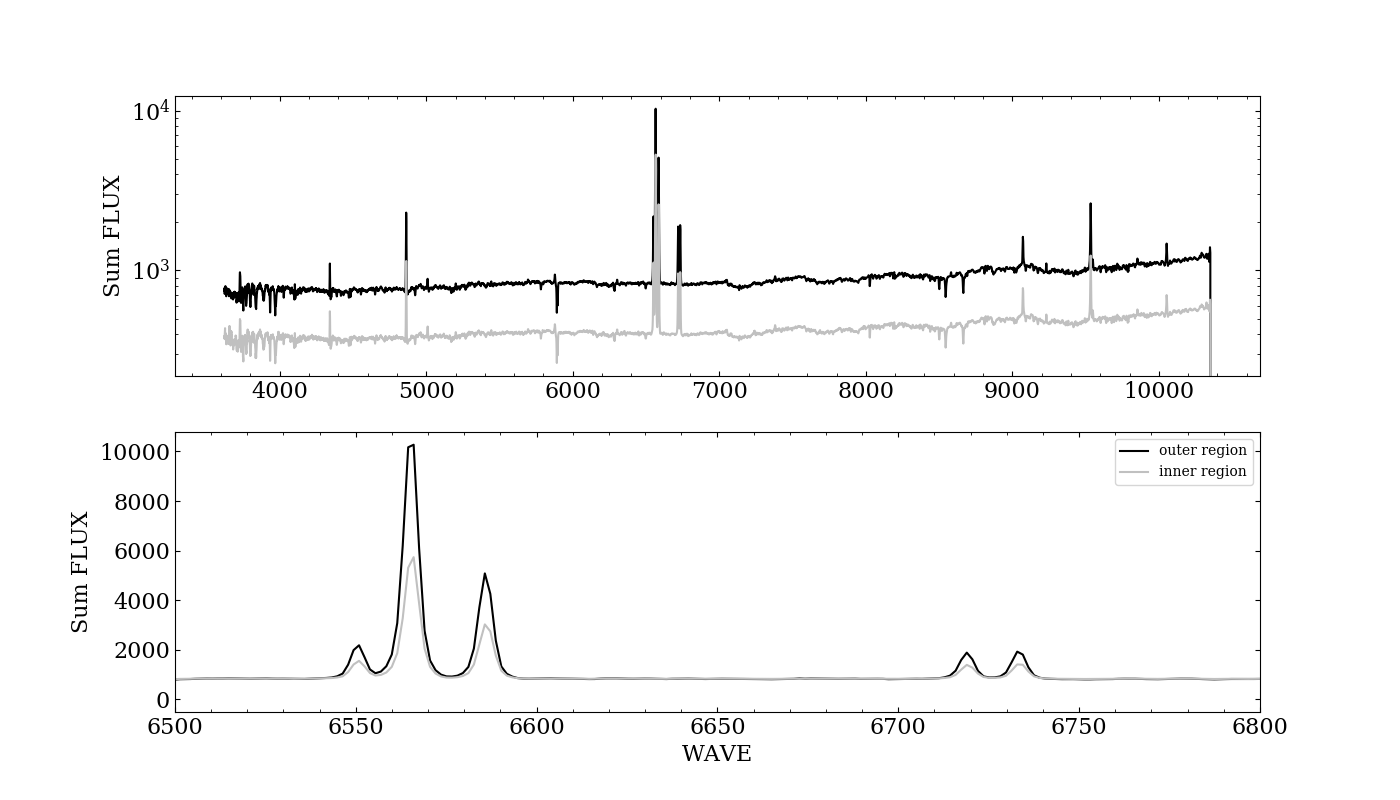

In [56]:
%matplot plt